<a href="https://colab.research.google.com/github/Ash100/MDS/blob/main/SSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install MDTraj and DSSP tool (mkdssp)
!pip install mdtraj
!apt install -y dssp  # installs mkdssp tool

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import mdtraj as md
import matplotlib.pyplot as plt
import numpy as np

# Load trajectory and topology
traj = md.load("/content/105_lig_prod1-20_wd_water.dcd", top="/content/105_lig_equil_1.pdb")

# Slice only the protein part
protein_traj = traj.atom_slice(traj.topology.select("protein"))

# Compute DSSP secondary structure (only for protein)
ss = md.compute_dssp(protein_traj, simplified=True)

# Map structure letters to integers
ss_map = {'H': 0, 'E': 1, 'C': 2}
ss_numeric = np.vectorize(ss_map.get)(ss)

# Plot
plt.figure(figsize=(12, 6))
plt.imshow(ss_numeric.T, aspect='auto', cmap='Set2', interpolation='nearest')
plt.xlabel('Frame')
plt.ylabel('Residue Index')
plt.title('Secondary Structure Over Time')
cbar = plt.colorbar(ticks=[0, 1, 2], label='Structure')
cbar.ax.set_yticklabels(['Helix (H)', 'Strand (E)', 'Coil (C)'])
plt.clim(-0.5, 2.5)

# Save high-resolution figure
plt.savefig("secondary_structure_timeline.png", dpi=600, bbox_inches='tight')
plt.show()

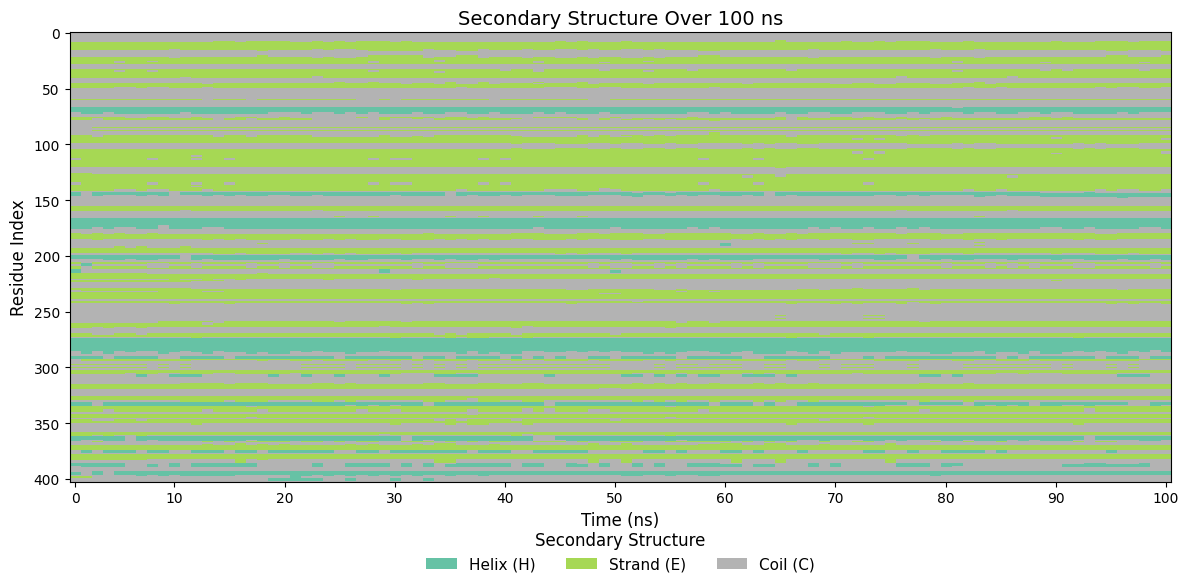

In [12]:
import mdtraj as md
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

# Load trajectory (every 10th frame: 100 frames = 100 ns)
traj = md.load("/content/drive/MyDrive/Dr_Zeeshan/3up/prot_lig_prod1-20_whole.dcd", top="/content/drive/MyDrive/Dr_Zeeshan/3up/prot_lig_equil.pdb", stride=10)

# Keep protein only
protein_traj = traj.atom_slice(traj.topology.select("protein"))

# Compute secondary structure
ss = md.compute_dssp(protein_traj, simplified=True)

# Convert to numeric
ss_map = {'H': 0, 'E': 1, 'C': 2}
ss_numeric = np.vectorize(ss_map.get)(ss)

# Time in ns: 100 frames = 100 ns
time = np.linspace(0, 100, ss.shape[0])

# Create plot
fig, ax = plt.subplots(figsize=(12, 6))
im = ax.imshow(ss_numeric.T, aspect='auto', cmap='Set2', interpolation='nearest')

# Labels and title
ax.set_xlabel('Time (ns)', fontsize=12)
ax.set_ylabel('Residue Index', fontsize=12)
ax.set_title('Secondary Structure Over 100 ns', fontsize=14)

# X-axis ticks at 10 ns intervals
tick_times = np.arange(0, 101, 10)  # 0 to 100 with step of 10
tick_locs = np.linspace(0, len(time) - 1, len(tick_times), dtype=int)
ax.set_xticks(tick_locs)
ax.set_xticklabels(tick_times)

# Clean legend
colors = plt.cm.Set2([0, 0.5, 1.0])
legend_elements = [
    mpatches.Patch(facecolor=colors[0], label='Helix (H)'),
    mpatches.Patch(facecolor=colors[1], label='Strand (E)'),
    mpatches.Patch(facecolor=colors[2], label='Coil (C)')
]
ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.08),
          ncol=3, frameon=False, fontsize=11, title="Secondary Structure", title_fontsize=12)

# Save high-res figure
plt.tight_layout()
plt.savefig("d105_ss.png", dpi=600, bbox_inches='tight')
plt.show()
